Approximating derivatives (1st, 2nd, etc, orders):    
https://www.dam.brown.edu/people/alcyew/handouts/numdiff.pdf   
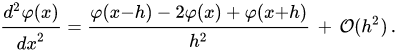    

*$O(x^n)$ term means that all remaining terms have powers of $x$ that are at least $n$.*    
*Remember LU decomposition can be applied to speed things up!*


Relaxation:     
https://en.wikipedia.org/wiki/Relaxation_(iterative_method)   
https://core.ac.uk/download/pdf/215674186.pdf

<span style="font-size:1.5em;">
The equation we want to solve is:    

$\frac{\partial u}{\partial t} - \alpha\nabla^2u = 0$

Where $\alpha$ = diffusivity constant
    
The definition of Laplacian operator ($\Delta f = \nabla^2f = \nabla \cdot \nabla f$):
    
$\nabla^2u = \frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}+\frac{\partial^2 u}{\partial z^2}$

Approximations: <br>
$\frac{\partial u}{\partial t} = \frac{u(t+1)-u(t)}{\Delta t}$ and becomes $\frac{u^{n+1}-u^n}{\Delta t}$ 
    
$\frac{\partial^2 u}{\partial t^2} = \frac{u(t-\Delta t)-2u(t)+u(t+\Delta t)}{\Delta t^2}$

With $\Delta x = \Delta y = \Delta z = 1$:

For 3D:<br>
$u^{n+1}_{i,j,k}=\alpha \Delta t({u^n}_{i+1,j,k}$+${u^n}_{i-1,j,k}$+${u^n}_{i,j+1,k}$+${u^n}_{i,j-1,k}$+${u^n}_{i,j,k+1}$+${u^n}_{i,j,k-1}$-$6{u^n}_{i,j,k})+u^{n}_{i,j,k}$
    
    
For 2D:<br>
$u^{n+1}_{i,j}=\alpha \Delta t({u^n}_{i+1,j}$+${u^n}_{i-1,j}$+${u^n}_{i,j+1}$+${u^n}_{i,j-1}$-$4{u^n}_{i,j})+u^{n}_{i,j}$

</span>

Apparently, the essential thing here is the boundary condition on the obstacle.

In [1]:
import time
from math import sqrt
import numpy as np
from scipy.optimize import minimize
from scipy.misc import derivative

import matplotlib.pyplot as plt

# import cupy as cp
# from numba import jit


# %matplotlib notebook

In [2]:
goal_x, goal_y = 20,50

plate_length = 60
plate_width = 50


alpha = 1000
max_sigma = 1
goal_value = 100000

delta_x = 1
delta_t = 0.0005

# Boundary conditions
boundary_val = 0

# Initial condition everywhere inside the grid
u_initial = 0

obs = np.full((plate_length,plate_width),False)
obs[32,10:31] = True
obs[28,14:27] = True
obs[20:32,10] = True
obs[20:28,14] = True
obs[20:32,30] = True
obs[20:28,26] = True
obs[20,10:15] = True
obs[20,27:31] = True
# obs[30,10:31] = True
# obs[20:30,10] = True
# obs[20:30,30] = True

def get_gamma(goal_x, goal_y, x=plate_width, y=plate_length):
    g = np.ones((y,x),dtype=float)
    for i in range(g.shape[0]):
        for j in range(g.shape[1]):
            #sigma = 1/(sqrt((j-goal_x)**2+(i-goal_y)**2)+1/max_sigma)
            sigma = 1/((abs(j-goal_x)+abs(i-goal_y))+1/max_sigma)
            g[i,j] = alpha*(sigma)
            #g[i,j] = alpha
    return g
            
gamma = get_gamma(goal_x, goal_y)


def set_boundaries(u):
    # Set the boundary conditions
    u[:, 0, :] = boundary_val
    u[:, :, 0] = boundary_val
    u[:, -1, :] = boundary_val
    u[:, :, -1] = boundary_val
    
    u[...,obs] = 0
    
    u[:,goal_y,goal_x] = goal_value
    
    return u


def initialize_u(max_iter_time, ni=plate_length, nj=plate_width):
    
    # Initialize solution: the grid of u(k, i, j)
    u = np.full((max_iter_time, ni, nj), u_initial, dtype=float)

    # Set the boundary conditions
    set_boundaries(u)
    
    return u


def calculate2D(u, teta=0.5, n_early_stop=10, epslon=1E-6):
    threshold = [0.0]
    early_stop = 0
    max_val = u.max()
    min_val = u.min()
    nk, ni, nj = u.shape
    prev_res = None
    for n in range(0, nk-1):
        A = u[n, 2:  , 1:-1] # u[k][i+1][j]
        B = u[n,  :-2, 1:-1] # u[k][i-1][j]
        C = u[n, 1:-1, 2:  ] # u[k][i][j+1]
        D = u[n, 1:-1,  :-2] # u[k][i][j-1]
        E = u[n, 1:-1, 1:-1] # u[k][i][j]

        result = delta_t*np.multiply(gamma[1:-1, 1:-1],(A+B+C+D-4*E)) + E
        
        # Set the newly computed heatmap at time k+1    
        u[n+1, 1:-1, 1:-1] = result
        set_boundaries(u)
        
        numerical_problem = False
        if (u[n+1, 1:-1, 1:-1]>max_val*1.1).any():
            print(f"[n={n+1}] Big value {u[n+1, 1:-1, 1:-1].max()} vs {max_val} found!")
            numerical_problem = True
        if (u[n+1, 1:-1, 1:-1]<min_val*1.1).any():
            print(f"[n={n+1}] Small value {u[n+1, 1:-1, 1:-1].min()} vs {min_val} found!")
            numerical_problem = True
        if numerical_problem:
            break
        
        # test if it's steady state
        threshold.append(abs(u[n+1, 1:-1, 1:-1]-u[n,1:-1,1:-1]).max())
        if abs(threshold[-1]-threshold[-2])<epslon:
            early_stop += 1
        if early_stop > n_early_stop:
            break
            
    return u, n+1

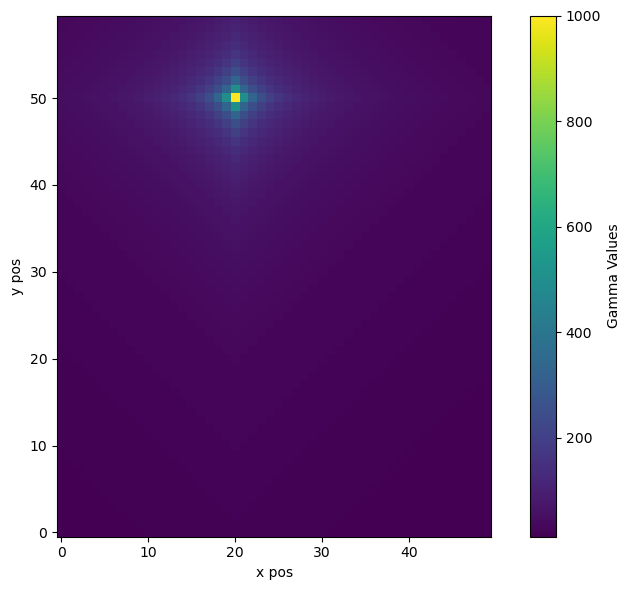

In [3]:
fig, ax = plt.subplots(figsize=(8,6))
mappable = ax.imshow(gamma, interpolation=None)#, cmap=plt.cm.jet)
fig.colorbar(mappable, label="Gamma Values")
ax.set_xlabel("x pos")
ax.set_ylabel("y pos")
ax.invert_yaxis()
fig.tight_layout()
plt.show()

In [4]:
tcalc = 3000

# create new map and display result
t_init = time.time()
u, tcalc = calculate2D(initialize_u(tcalc), epslon=1E-3)
t_final = time.time()
print(f"Stopped at step {tcalc} | Total time: {t_final-t_init}s")
uf = u[tcalc]

Stopped at step 2539 | Total time: 8.6855788230896s


In [5]:
# %debug

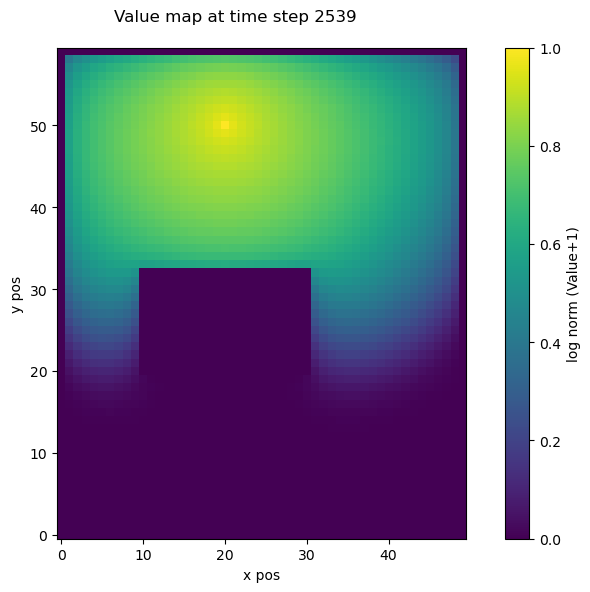

In [5]:
tshow = tcalc

fig, ax = plt.subplots(figsize=(8,6))

u_log = np.log(u[tshow]+1)
u_log_norm = (u_log - u_log.min())/(u_log.max()-u_log.min())
mappable = ax.imshow(u_log_norm, interpolation=None)#, cmap=plt.cm.jet)
fig.colorbar(mappable, label="log norm (Value+1)")
ax.set_xlabel("x pos")
ax.set_ylabel("y pos")
fig.suptitle(f"Value map at time step {tcalc}")
fig.tight_layout()
ax.invert_yaxis()
plt.show()

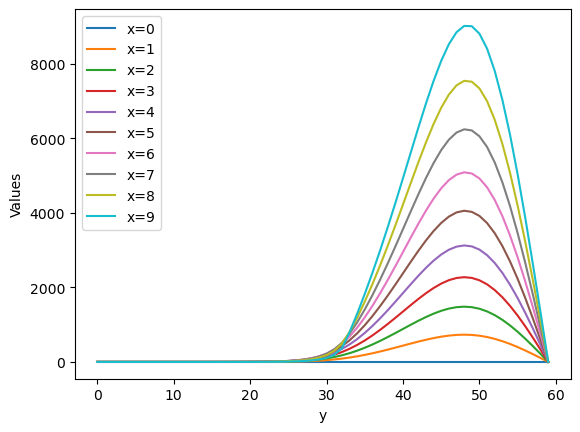

In [6]:
plt.plot((u[tshow])[:,0:10], label=[f"x={i}" for i in range(10)])
plt.xlabel("y")
plt.ylabel("Values")
plt.legend()
plt.show()

In [7]:
# x0 = 29,29
# x0 = 11,29
x0 = 15,22
# x0 = 18,22
# x0 = 5,10

In [8]:
uf.shape

(60, 50)

In [9]:
def func(x, uf=uf):
    x,y = x
    
    return uf[round(y),round(x)]

In [10]:
def part_derivative(func,x,y,dx=1,dy=1):
    d1 = derivative(lambda x,y: func([x,y]), x, dx, args=(y,))
    d2 = derivative(lambda y,x: func([x,y]), y, dx, args=(x,))
    return np.array([d1,d2])

In [11]:
part_derivative(func,x0[0],x0[1])

/tmp/ipykernel_330281/3336221298.py:2: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d1 = derivative(lambda x,y: func([x,y]), x, dx, args=(y,))
/tmp/ipykernel_330281/3336221298.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d2 = derivative(lambda y,x: func([x,y]), y, dx, args=(x,))


array([ 0.00015311, -0.00021655])

In [12]:
def gradient_descent_of_sorts(func, start, min_val, learn_rate=0.1, n_iter=50):
    vector = [start]
    tolerance=min_val*0.1
    for _ in range(n_iter):
        grad = part_derivative(func,vector[-1][0],vector[-1][1])
        diff = -learn_rate * grad/np.linalg.norm(grad)
        vector.append(vector[-1]+diff)
        if abs(func(vector[-1])-min_val)<tolerance:
            break
    return np.array(vector)

In [13]:
steps = gradient_descent_of_sorts(func, x0, uf.min(), -0.5, n_iter=tcalc)

/tmp/ipykernel_330281/3336221298.py:2: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d1 = derivative(lambda x,y: func([x,y]), x, dx, args=(y,))
/tmp/ipykernel_330281/3336221298.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d2 = derivative(lambda y,x: func([x,y]), y, dx, args=(x,))


Obstacles must be something that doesn't propagates the heat and only the boundary conditions would do the rest of the trick...    
My current system the obstacles generate local minimas.

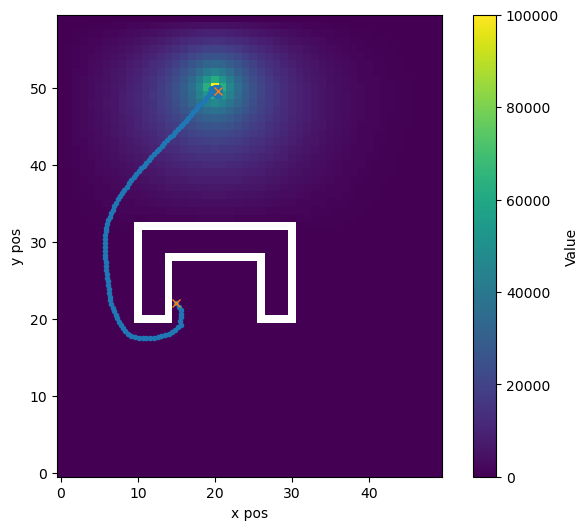

In [14]:
img = uf.copy()
# Result
fig, ax = plt.subplots(figsize=(8,6))
mappable = ax.imshow(img, interpolation=None, vmin=u.min(), 
                                              vmax=u.max())#, cmap=plt.cm.jet)
fig.colorbar(mappable, label="Value")
# Obstacles, in black
img_obs = img.copy()
img_obs.fill(np.nan) # nan is ignored
img_obs[obs] = 255
ax.imshow(img_obs, interpolation=None, vmin=0, cmap=plt.cm.hot)
plt.plot(steps[:,0],steps[:,1],'.-')
plt.plot(steps[[0,-1],0],steps[[0,-1],1],'x')
ax.set_xlabel("x pos")
ax.set_ylabel("y pos")
ax.invert_yaxis()
plt.show()

## 3D

In [15]:
goal_x, goal_y, goal_z = 20,50,5

plate_length = 60
plate_width = 50
plate_height = 10

max_sigma = 100
alpha = 20

delta_x = 1
delta_t = 0.0005


# Boundary conditions (must be bigger than zero)
boundary_val = 0

# Initial condition everywhere inside the grid
u_initial = 0 # non-zero, please

obs = np.full((plate_height,plate_length,plate_width),False)
obs[:,30,10:31] = True
obs[:,20:30,10] = True
obs[:,20:30,30] = True

def get_gamma3D(goal_x, goal_y, goal_z, x=plate_width, y=plate_length, z=plate_height):
    g = np.ones((z,y,x),dtype=float)
    for i in range(g.shape[0]):
        for j in range(g.shape[1]):
            for k in range(g.shape[2]):
                #sigma = 1/((sqrt((k-goal_x)**2+(j-goal_y)**2+(i-goal_z)**2)+1/max_sigma))
                #g[i,j,k] = alpha*(sigma)
                g[i,j] = alpha
    return g
            
gamma3D = get_gamma3D(goal_x, goal_y, goal_z)

def set_boundaries(u):
    # Set the boundary conditions
    u[:, 0, :, :] = boundary_val  #z=min
    u[:, -1, :, :] = boundary_val #z=max
    u[:, :, 0, :] = boundary_val  #y=min
    u[:, :, -1, :] = boundary_val #y=max
    u[:, :, :, 0] = boundary_val  #x=min
    u[:, :, :, -1] = boundary_val #x=max

    
    u[...,obs] = 0
    
    u[:,goal_z,goal_y,goal_x] = 5000000
    
    return u


def initialize_u(max_iter_time, ni=plate_length, nj=plate_width, nk=plate_height):
    
    # Initialize solution: the grid of u(k, i, j)
    u = np.full((max_iter_time, nk, ni, nj), u_initial, dtype=float)

    # Set the boundary conditions
    set_boundaries(u)
    
    return u


def calculate3D(u, teta=0.5, n_early_stop=10, epslon=1E-6):
    threshold = [0.0]
    early_stop = 0
    max_val = u.max()
    min_val = u.min()
    nt, _, _, _ = u.shape
    prev_res = None
    for n in range(0, nt-1):
        A = u[n,1:-1, 2:  , 1:-1]  # u[n][i+1][j][k]
        B = u[n,1:-1,  :-2, 1:-1]  # u[n][i-1][j][k]
        C = u[n,1:-1, 1:-1, 2:  ]  # u[n][i][j+1][k]
        D = u[n,1:-1, 1:-1,  :-2]  # u[n][i][j-1][k]
        E = u[n, 1:-1, 1:-1, 1:-1] # u[n][i][j][k]
        F = u[n, 2:  , 1:-1, 1:-1] # u[n][i][j][k+1]
        G = u[n,  :-2, 1:-1, 1:-1] # u[n][i][j][k-1]

        result = delta_t*np.multiply(gamma3D[1:-1, 1:-1, 1:-1],(A+B+C+D+F+G-6*E)) + E
        
        
        # Set the newly computed heatmap at time k+1
        u[n+1, 1:-1, 1:-1, 1:-1] = result
        
        set_boundaries(u)
         
        numerical_problem = False
        if (u[n+1, 1:-1, 1:-1]>max_val*1.1).any():
            print(f"[n={n+1}] Big value {u[n+1, 1:-1, 1:-1, 1:-1].max()} vs {max_val} found!")
            numerical_problem = True
        if (u[n+1, 1:-1, 1:-1]<min_val*1.1).any():
            print(f"[n={n+1}] Small value {u[n+1, 1:-1, 1:-1, 1:-1].min()} vs {min_val} found!")
            numerical_problem = True
        if numerical_problem:
            break
                    
        # test if it's steady state
        threshold.append(abs(u[n+1, 1:-1, 1:-1, 1:-1]-u[n,1:-1,1:-1,1:-1]).max())
        if abs(threshold[-1]-threshold[-2])<epslon:
            early_stop += 1
        if early_stop > n_early_stop:
            break
                        
    return u, n+1

In [16]:
gamma3D.min(),gamma3D.max()

(20.0, 20.0)

In [17]:
tcalc = 3000

# create new map and display result
t_init = time.time()
u, tcalc = calculate3D(initialize_u(tcalc), epslon=1E-3)
t_final = time.time()
print(f"Stopped at step {tcalc} | Total time: {t_final-t_init}s")
uf3D = u[tcalc]

Stopped at step 2999 | Total time: 133.50091910362244s


In [18]:
# %debug

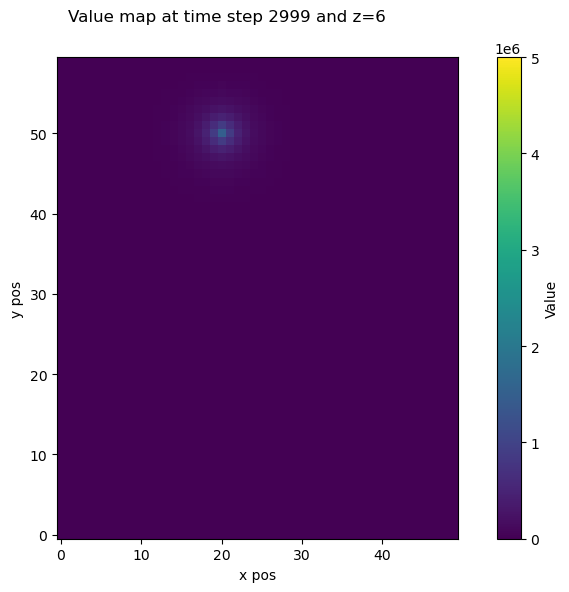

In [19]:
tshow = tcalc
z = 6

fig, ax = plt.subplots(figsize=(8,6))
mappable = ax.imshow(u[tshow,z,...], interpolation=None, vmin=u.min(), 
                                                         vmax=u.max())#, cmap=plt.cm.jet)
fig.colorbar(mappable, label="Value")
ax.set_xlabel("x pos")
ax.set_ylabel("y pos")
fig.suptitle(f"Value map at time step {tcalc} and z={z}")
fig.tight_layout()
ax.invert_yaxis()
plt.show()

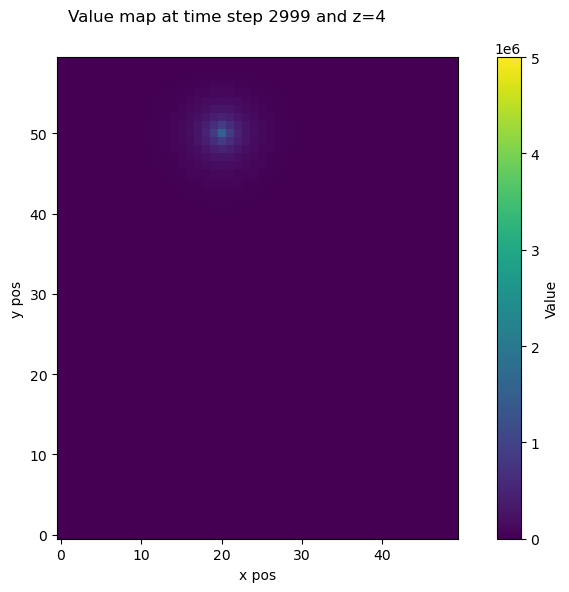

In [20]:
tshow = tcalc
z = 4

fig, ax = plt.subplots(figsize=(8,6))
mappable = ax.imshow(u[tshow,z,...], interpolation=None, vmin=u.min(), 
                                                         vmax=u.max())#, cmap=plt.cm.jet)
fig.colorbar(mappable, label="Value")
ax.set_xlabel("x pos")
ax.set_ylabel("y pos")
fig.suptitle(f"Value map at time step {tcalc} and z={z}")
fig.tight_layout()
ax.invert_yaxis()
plt.show()

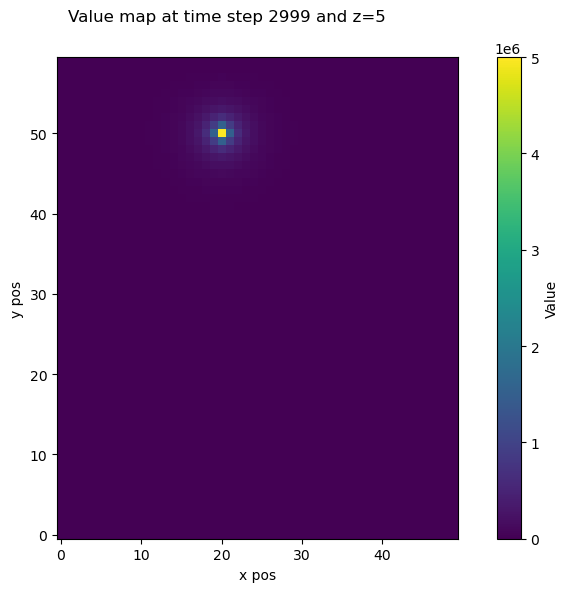

In [21]:
tshow = tcalc
z = 5

fig, ax = plt.subplots(figsize=(8,6))
mappable = ax.imshow(u[tshow,z,...], interpolation=None, vmin=u.min(), 
                                                         vmax=u.max())#, cmap=plt.cm.jet)
fig.colorbar(mappable, label="Value")
ax.set_xlabel("x pos")
ax.set_ylabel("y pos")
fig.suptitle(f"Value map at time step {tcalc} and z={z}")
fig.tight_layout()
ax.invert_yaxis()
plt.show()

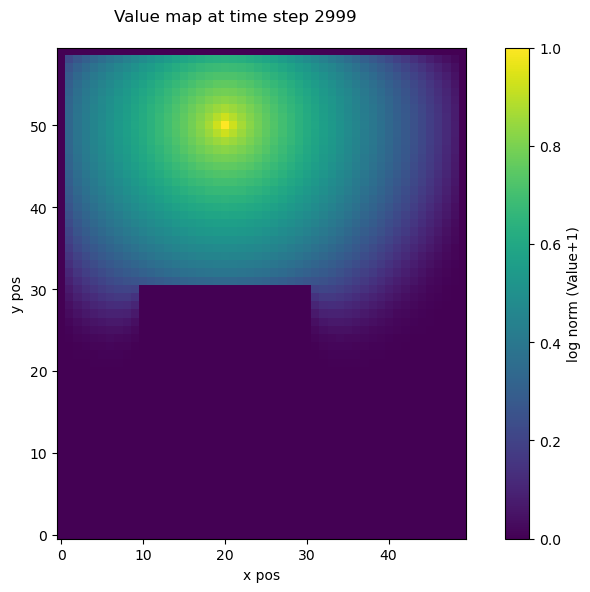

In [22]:
tshow = tcalc
z = 5

fig, ax = plt.subplots(figsize=(8,6))

u_log = np.log(u[tshow,z,...]+1)
u_log_norm = (u_log - u_log.min())/(u_log.max()-u_log.min())
mappable = ax.imshow(u_log_norm, interpolation=None)#, cmap=plt.cm.jet)
fig.colorbar(mappable, label="log norm (Value+1)")
ax.set_xlabel("x pos")
ax.set_ylabel("y pos")
fig.suptitle(f"Value map at time step {tcalc}")
fig.tight_layout()
ax.invert_yaxis()
plt.show()

In [23]:
uf = u[tshow,z,...]

In [24]:
x0 = 20,25
# x0 = 29,29
# x0 = 11,29
x0 = 15,22
# x0 = 18,22

In [25]:
part_derivative(func,x0[0],x0[1])

/tmp/ipykernel_330281/3336221298.py:2: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d1 = derivative(lambda x,y: func([x,y]), x, dx, args=(y,))
/tmp/ipykernel_330281/3336221298.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d2 = derivative(lambda y,x: func([x,y]), y, dx, args=(x,))


array([ 0.00015311, -0.00021655])

In [27]:
steps = gradient_descent_of_sorts(func, x0, uf.min(), -0.5, n_iter=tcalc)

/tmp/ipykernel_330281/3336221298.py:2: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d1 = derivative(lambda x,y: func([x,y]), x, dx, args=(y,))
/tmp/ipykernel_330281/3336221298.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d2 = derivative(lambda y,x: func([x,y]), y, dx, args=(x,))


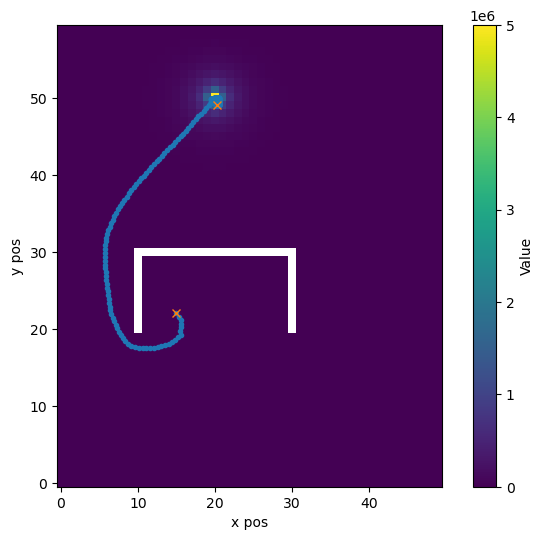

In [28]:
img = uf.copy()
# Result
fig, ax = plt.subplots(figsize=(8,6))
mappable = ax.imshow(img, interpolation=None, vmin=u.min(), 
                                              vmax=u.max())#, cmap=plt.cm.jet)
fig.colorbar(mappable, label="Value")
# Obstacles, in black
img_obs = img.copy()
img_obs.fill(np.nan) # nan is ignored
img_obs[obs[z,...]] = 255
ax.imshow(img_obs, interpolation=None, vmin=0, cmap=plt.cm.hot)
ax.set_xlabel("x pos")
ax.set_ylabel("y pos")
plt.plot(steps[:,0],steps[:,1],'.-')
plt.plot(steps[[0,-1],0],steps[[0,-1],1],'x')
ax.invert_yaxis()
plt.show()

In [29]:
def func3D(x, uf=uf3D):
    x,y,z = x
    
    return uf[round(z),round(y),round(x)]

In [30]:
def part_derivative3D(func3D,x,y,z,dx=1,dy=1,dz=1):
    d1 = derivative(lambda x,y,z: func3D([x,y,z]), x, dx, args=(y,z))
    d2 = derivative(lambda y,x,z: func3D([x,y,z]), y, dy, args=(x,z))
    d3 = derivative(lambda z,x,y: func3D([x,y,z]), z, dz, args=(x,y))
    return np.array([d1,d2,d3])

In [31]:
def gradient_descent_of_sorts3D(func3D, start, min_val, learn_rate=0.1, n_iter=50):
    vector = [np.array(start)]
    tolerance=min_val*0.1
    for _ in range(n_iter):
        grad = part_derivative3D(func3D,vector[-1][0],vector[-1][1],vector[-1][2])
        diff = -learn_rate * grad/np.linalg.norm(grad)
        vector.append(vector[-1]+diff)
        try:
            if abs(func3D(vector[-1])-min_val)<tolerance:
                break
        except:
            return vector
    return np.array(vector)

In [32]:
x0_3D = x0[0],x0[1],5
steps = gradient_descent_of_sorts3D(func3D, x0_3D, uf.min(), -0.5, n_iter=tcalc)

/tmp/ipykernel_330281/15641439.py:2: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d1 = derivative(lambda x,y,z: func3D([x,y,z]), x, dx, args=(y,z))
/tmp/ipykernel_330281/15641439.py:3: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d2 = derivative(lambda y,x,z: func3D([x,y,z]), y, dy, args=(x,z))
/tmp/ipykernel_330281/15641439.py:4: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  d3 = derivative(lam

In [33]:
steps

array([[15.        , 22.        ,  5.        ],
       [14.6517117 , 21.64330321,  4.96175523],
       [14.3034234 , 21.28660642,  4.92351045],
       ...,
       [19.73815524, 49.72324767,  4.2409376 ],
       [19.73815524, 49.72319859,  4.74093759],
       [19.73815533, 49.71260738,  4.24104978]])

(0.0, 8.0)

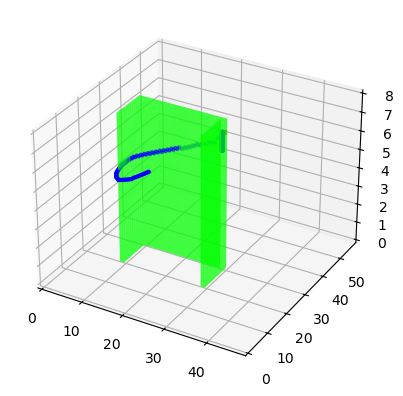

In [34]:
uf3D_plot = np.swapaxes(uf3D[1:-1,1:-1,1:-1],0,2)
max_plot_val = uf3D_plot.max()
uf3D_gtz = np.argwhere(uf3D_plot>0)
alphas = np.array([uf3D_plot[i[0],i[1],i[2]] for i in uf3D_gtz])
alphas /= max_plot_val
# alphas = (np.log(alphas)-np.log(alphas).min())
# alphas /= alphas.max()

# uf3D_zeros = np.argwhere(uf3D_plot == 0)
uf3Dv = np.swapaxes(uf3D,0,2)
# Create Data
data = uf3D_plot == 0
# Control colour
colors = np.empty(list(data.shape) + [4], dtype=np.float32)
colors[:] = [0, 1, 0, 0.5]  # RGBA with Alpha=0)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# alpha=
# ax.scatter(uf3D_gtz[:,0], uf3D_gtz[:,1], uf3D_gtz[:,2], c='r', marker='.', s=10*alphas)#, alpha=alphas)
# ax.scatter(uf3D_zeros[:,0], uf3D_zeros[:,1], uf3D_zeros[:,2], c='k', marker='.')
ax.voxels(data, shade=False, facecolors=colors)
ax.scatter(steps[:,0], steps[:,1], steps[:,2], c='b', marker='.')
ax.scatter([goal_x], [goal_y], [goal_z], c='r', marker='x', s=10)
ax.set_xlim3d(0,uf3D_plot.shape[0])
ax.set_ylim3d(0,uf3D_plot.shape[1])
ax.set_zlim3d(0,uf3D_plot.shape[2])
# ax.invert_xaxis()
# ax.invert_yaxis()

In [149]:
# # Create axis
# # axes = list(uf3D_plot.shape)
 
# uf3Dv = np.swapaxes(uf3D,0,2)

# # Create Data
# data = uf3Dv>0 #np.ones(axes, dtype=bool)

# # Control colour
# colors = np.empty(list(data.shape) + [4], dtype=np.float32)
 
# colors[:] = [1, 0, 0, .5]  # red (transparent, RGBA with Alpha=0)

# # Control Transparency
# (colors[:,:,:,0])[uf3Dv>0] = 10*(uf3Dv[uf3Dv>0]+10000)/uf3Dv[uf3Dv>0].max()


# # Plot figure
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
 
# # Voxels is used to customizations of the
# # sizes, positions and colors.
# ax.voxels(data, shade=False, facecolors=colors)
# plt.show()

In [ ]:
# Another thing to have a look https://docs.scipy.org/doc/scipy/reference/sparse.csgraph.html